In [1]:
import tensorflow as tf

In [3]:
tf.Session().run(tf.add(40,2))

42

In [1]:
#Imports

from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

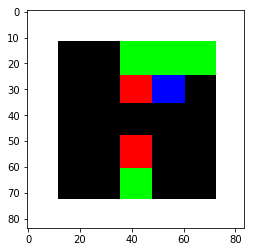

In [2]:
#Load game env

from gridworld import gameEnv
env = gameEnv(partial=False, size=5)

In [4]:
class Qnetwork():
    def __init__(self, H_SIZE):
        #h_size is number of output filters at the end of the final conv layer
        #In a regular DQN, this would just get flattened to get the Q-values for all actions
        #But here these output filter maps are going to be sent to the V and A networks
        
        #We get frame, flatten it using def processState(states) and then reshape it here
        
        self.scalarInput = tf.placeholder(shape=[None, 84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1, 84, 84, 3])
        
        #CNN layers
        
        self.conv1 = slim.conv2d( 
            inputs=self.imageIn,
            num_outputs=32,
            kernel_size=[8,8],
            stride=[4,4],
            padding='VALID',
            biases_initializer=None
        )
        
        self.conv2 = slim.conv2d( 
            inputs=self.conv1,
            num_outputs=64,
            kernel_size=[4,4],
            stride=[2,2],
            padding='VALID',
            biases_initializer=None
        )        
        
        self.conv3 = slim.conv2d( 
            inputs=self.conv2,
            num_outputs=64,
            kernel_size=[3,3],
            stride=[1,1],
            padding='VALID',
            biases_initializer=None
        )
        
        self.conv4 = slim.conv2d( 
            inputs=self.conv3,
            num_outputs=h_size,
            kernel_size=[7,7],
            stride=[1,1],
            padding='VALID',
            biases_initializer=None
        )
        
        # In a regular DQN we'd flatten now and use Fully Connected layers
        # But here we split these feature maps in two streams and then flatten them 
        # Could we have flattened and then split?
        
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3) #Split conv4 output into 2 parts, along last axis
        # Last axis here no longer denotes color 
        
        #Flatten
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        #We put both A and V streams through 1 fully connected layer
        #So we need weight matrices for both
        #Random normal initialization
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions])) 
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        #Advantage values will be 1 per action based on the state
        #But just 1 V value for the state
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        #We find net advantage above and over the average advantage
        self.netAdv = tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        #Now we add V value and net advantage to get final Q value
        self.Qout = self.Value + self.netAdv
        #Why + and not tf.add or something??
        #Now we predict the Q values for all actions that could be taken from this state
        #We could have done this in a loop i.e.1 Q value for the state + one particular action
        #But we save time by predicting all the Q values and then taking the action with the largest Q
        self.predict = tf.argmax(self.Qout,1)
        
        #Now finally we have made a prediction. Now starts the backward pass
        # We need to calc the TD error i.e. MSE between targetQ and Q
        #targetQ is coming from the target network at run time
        
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32) 
        
        
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32 ) 
        #In Double DQN the action predicted by the main network isn't whose Q value we use
        #self.predict is the action that we have to take
        #But it's Q value is actually overestimated, so we give that action to the 
        #Note that this class will represent both Target and Main networks, so it needs to have variables
        #that either one might need.
        
        #That's why there is self.actions to receive the action integer
        #This integer is converted to its corresp Q value by multiplying with the action's one-hot
        #representation and then reduce-summing it. All the other Q values will be multiplied by 0 except 
        #the one corresp to self.actions
        #Had it been the usual DQN, we'd have taken self.predict action and used it's corresp self.Q value
        #But here we have to send the chosen action (by the main network) to the target network to find out
        #what the target network thinks about the Q value, then use that
        
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype-tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        #Now the td error
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        #self.Q is a 1D matrix with a particular action's Q value non-zero and rest 0
        #self.targetQ has different values coming from target network for the same state
        
        #Once the loss function has been defined, its all a matter of backprop
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
        
        
        
        
        
        
         

Experience Replay

In [6]:
#Class to store exp and then sample to train

class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        #If its going to overflow, then remove those many from the start  
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer) - self.buffer_size)] = [] # This [] deletes, not adds a [] in its place
        self.buffer.extend(experience) #Append would have "broken" the smooth array by inserting a sublist
        #rather than concatenating the elements of the sublist
        
    def sample(self, size):
        sm = np.array(random.sample(self.buffer, size))
        return(np.reshape(sm, [size, 5]))
    


In [7]:
#Other functions

#To resize game frames
def processState(states):
    return(np.reshape(states, [21168]))

#These two functions allow us to update target network with parameters of primary network

def updateTargetGraph(tfVars, TAU):
    total_vars = len(tfVars)
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        addedVal = ( var.value()*TAU ) + ( tfVars[idx+total_vars//2]*(1 - TAU) )
        newVal = tfVars[idx+total_vars//2].assign(addedVal)
        op_holder.append(newVal)
        #The second half of tfVars are the vars belonging to the target network
        #1-TAU is like 99.999% , so vast majority of the target network is retained
        #Only a small fraction TAU change is allowed based on the main network
        return(op_holder)
    
def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)
#Op holder contains ops, where each op is a weight average update op (using TAU and 1-TAU)
#When each sess.run is executed, the target network gets updated one var at a time

In [8]:
#Constants and Parameters 

BATCH_SIZE = 32 #No. of exps per training step
UPDATE_FREQ = 4 # Every how many iters of gameplay should training be done(gameplay will continue regardless of training)
GAMMA = .99 #Discount factor

H_SIZE = 512 #How many filters in final conv layer, multiple of 2 as we are going to split it
TAU = 0.001 #How much to update target network gradually

START_E = 1 #Start exploration randomness
END_E =0.1 #End exploration randomness

ANNEALING_STEPS = 10000
NUM_EPISODES = 10000

PRE_TRAIN_STEPS = 10000 #Warm up to collect experinces before training starts. Purely random actions
MAX_EP_LENGTH = 50 #How long each episode

LOAD_MODEL = False #Don't use saved model
PATH = "./dqn" #Where to save model






Training Code

In [9]:
tf.reset_default_graph() #Reset

init = tf.global_variables_initializer() #Initialize all vars
saver = tf.train.Saver() # For saving model
trainables = tf.trainable_variables() # Returns all variables created with trainable=True i.e. what all can be trained

mainQN = Qnetwork(H_SIZE)
targetQN = Qnetwork(H_SIZE) #Idenitical networks
myBuffer = experience_buffer()

#Set exploration rate decrease

e = START_E
stepDrop = (START_E - END_E)/ANNEALING_STEPS

#Hold total reward and reward per ep
jList = []
rList = []
total_steps = 0


#Make path
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
    
#Now we start the session in which we will build and train

with tf.Session() as sess:
    sess.run(init) #Init op has been run
    
    #In case we are using a trained model
    if LOAD_MODEL == True:
        print('Loading model...')
        ckpt = tf.train.get_checkpoint_state(PATH) #Checkpoint
        saver.restore(sess, ckpt.model_checkpoint_path )
        
        
    updateTarget(targetOps, sess) #Using this session, update the target network with TAU part of main network
    
    
    #Actual running of episode starts here
    
    for i in range(NUM_EPISODES):
        

    
        
    
    

    



IndentationError: expected an indented block (<ipython-input-9-4408b5fe3203>, line 32)